In [1]:
%load_ext autoreload

In [48]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib import font_manager
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
from spynal.spikes import density
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *

plt.style.use('../sci_style.py')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"
data_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/figure_data"

# Load Data

In [4]:
# # session = 'Mary-Anesthesia-20160912-02'
# session = 'MrJones-Anesthesia-20160109-01'
# # session = 'Mary-Anesthesia-20160826-02'
# # session = 'MrJones-Anesthesia-20160107-01'
# # session = 'Mary-Anesthesia-20160822-02'
# # session = 'MrJones-Anesthesia-20160113-01'
# # session = 'Mary-Anesthesia-20160809-01'
# # session = 'MrJones-Anesthesia-20160121-01'
# # session = 'Mary-Anesthesia-20160831-02'
# # session = 'MrJones-Anesthesia-20160105-01'

# # session_list = ['Mary-Anesthesia-20160912-02',
# # 'MrJones-Anesthesia-20160109-01',
# # 'Mary-Anesthesia-20160826-02',
# # 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False

results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [5]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [6]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [7]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [8]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [9]:
section_times

{'wake': (0, 3548.040266666667),
 'induction': (3548.040266666667, 4441.511966666667),
 'anesthesia': (4441.511966666667, 7148.040266666667),
 'recovery': (7148.040266666667, 12191.767)}

In [10]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

# Sample Times

In [11]:
wake_bounds = section_times['wake']
anesthesia_bounds = (session_info['drugStart'][0] + 15*60, session_info['drugEnd'][1] - 15*60)

In [12]:
num_samples = 10

In [13]:
wake_times = np.sort(np.random.uniform(wake_bounds[0], wake_bounds[1], size=(num_samples,)))
anesthesia_times = np.sort(np.random.uniform(anesthesia_bounds[0], anesthesia_bounds[1], size=(num_samples,)))

In [14]:
np.array([float(f"{t:.3f}") for t in np.hstack([wake_times, anesthesia_times])])

array([ 345.797,  453.569,  599.868,  768.357, 1128.869, 1164.338,
       1757.345, 1933.507, 3002.665, 3325.113, 4623.271, 4633.451,
       4733.598, 4764.55 , 4912.15 , 5154.946, 5195.816, 5205.157,
       5558.773, 5577.738])

# Test

In [58]:
grid_search_results_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results"

In [61]:
grid_results = compile_grid_results(session, grid_search_results_dir, areas=['all'])

In [65]:
window, matrix_size, rank, _ = combine_grid_results(grid_results)

In [28]:
directory = pd.read_pickle(os.path.join(all_data_dir, data_class, f"{session}_lfp_chunked_20s", "directory"))

In [37]:
wake_t = wake_times[-3]
anesthesia_t = anesthesia_times[-3]

In [51]:
lfp_wake = load_window_from_chunks(wake_t, wake_t + 15, directory)
lfp_wake_rr = lfp_wake - np.expand_dims(lfp_wake.mean(axis=-1), -1)
lfp_anesthesia = load_window_from_chunks(anesthesia_t, anesthesia_t + 15, directory)
lfp_anesthesia_rr = lfp_anesthesia - np.expand_dims(lfp_anesthesia.mean(axis=-1), -1)

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --------------------
# FIT DELASE
# --------------------
stability_params = []
for sig in tqdm([lfp_wake, lfp_wake_rr, lfp_anesthesia, lfp_anesthesia_rr]):

    delase = DeLASE(sig, 
        matrix_size=matrix_size,
        rank=rank,
        dt=dt,
        max_freq=500,
        max_unstable_freq=125,
        device=device,
        verbose=True
        )
    delase.fit()
    
    stability_params.append(delase.stability_params.cpu().numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing jacobians...
Computing DDE characteristic roots...
Characteristic root computation complete!
Filtering characteristic roots...
None None
Stability analysis complete
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing jacobians...
Computing DDE characteristic roots...
Characteristic root computation complete!
Filtering characteristic roots...
None None
Stability analysis complete
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing jacobians...
Computing DDE characteristic roots...
Characteristic root computation complete!
Filtering characteristic roo

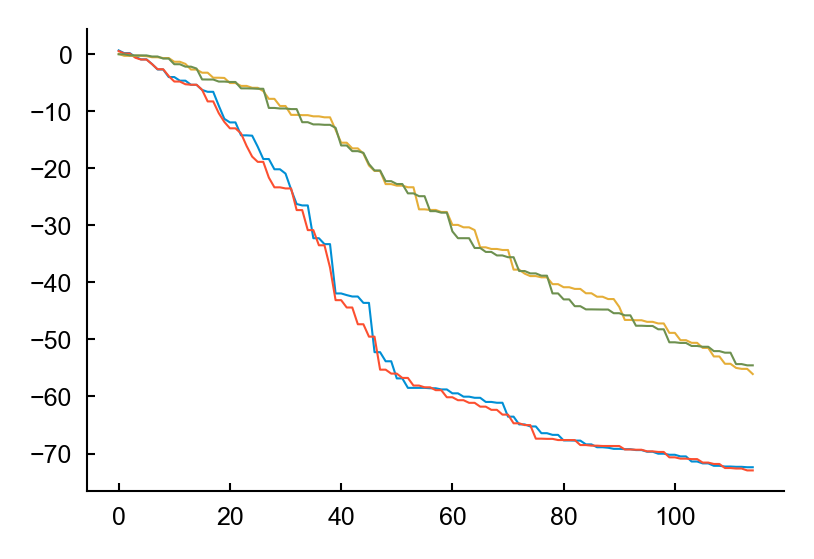

In [71]:
for stability_param in stability_params:
    
    plt.plot(stability_param[:int(len(stability_param)*0.1)])